# Library

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from analysis import *
from utils import *

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, confusion_matrix

# Data

In [96]:
df = pd.read_csv(
    r'../../data/cleaned/clean3.csv',
    encoding='utf-8',
)

In [97]:
df.head()

,price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,...,product_type,sku,customer_demographics,shipping_carriers,location,inspection_results,transportation_modes,routes,shipping_times_category,supplier_name
0,69.808006,55,802,8661.996792,58,7,96,4,2.956572,29,...,haircare,SKU0,Non-binary,Carrier B,Mumbai,Pending,Road,Route B,Standard,Supplier 3
1,14.843523,95,736,7460.900065,53,30,37,2,9.716575,23,...,skincare,SKU1,Female,Carrier A,Mumbai,Pending,Road,Route B,Express,Supplier 3
2,11.319683,34,8,9577.749626,1,10,88,2,8.054479,12,...,haircare,SKU2,Unknown,Carrier B,Mumbai,Pending,Air,Route C,Express,Supplier 1
3,61.163343,68,83,7766.836426,23,13,59,6,1.729569,24,...,skincare,SKU3,Non-binary,Carrier C,Kolkata,Fail,Rail,Route A,Standard,Supplier 5
4,4.805496,26,871,2686.505152,5,3,56,8,3.890548,5,...,skincare,SKU4,Non-binary,Carrier A,Delhi,Fail,Air,Route A,Economy,Supplier 1


# Load metadata

In [98]:
df = load_metadata(
    df,
    r"../../data/metadata/metadata3.json",
)

# Overview

## Check

In [99]:
print(f"Num of varibles:", df.shape[1])
print(f"Num of rows:", df.shape[0])

Num of varibles: 25
Num of rows: 100


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   price                    100 non-null    float64 
 1   availability             100 non-null    int64   
 2   number_of_products_sold  100 non-null    int64   
 3   revenue_generated        100 non-null    float64 
 4   stock_levels             100 non-null    int64   
 5   lead_times               100 non-null    int64   
 6   order_quantities         100 non-null    int64   
 7   shipping_times           100 non-null    int64   
 8   shipping_costs           100 non-null    float64 
 9   lead_time                100 non-null    int64   
 10  production_volumes       100 non-null    int64   
 11  manufacturing_lead_time  100 non-null    int64   
 12  manufacturing_costs      100 non-null    float64 
 13  defect_rates             100 non-null    float64 
 14  costs      

In [101]:
df.isnull().sum()

price                      0
availability               0
number_of_products_sold    0
revenue_generated          0
stock_levels               0
lead_times                 0
order_quantities           0
shipping_times             0
shipping_costs             0
lead_time                  0
production_volumes         0
manufacturing_lead_time    0
manufacturing_costs        0
defect_rates               0
costs                      0
product_type               0
sku                        0
customer_demographics      0
shipping_carriers          0
location                   0
inspection_results         0
transportation_modes       0
routes                     0
shipping_times_category    0
supplier_name              0
dtype: int64

## Varibles and target

In [102]:
target = ['supplier_name']
variablies = [col for col in df.columns if col not in target]

print(target)
print(variablies)

['supplier_name']
['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs', 'product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category']


# Grouping Varibles by their respective data types

In [103]:
numerical_cols, categorical_cols, _ = group_columns_by_type(df, display_info=True)

Total numeric columns: 15
Numeric columns: ['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs']

Total categorical columns: 10
Categorical columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category', 'supplier_name']



# Multivariate

In [104]:
df_numerical = df[numerical_cols].copy()
df_categorical = df[categorical_cols].copy()

In [105]:
encoder = OrdinalEncoder(
    categories=[["Supplier 1", "Supplier 2", "Supplier 3", "Supplier 4", "Supplier 5"]]
)
df["supplier_name"] = encoder.fit_transform(df[["supplier_name"]])
df["supplier_name"].unique()

array([2., 0., 4., 3., 1.])

## Correlation

In [106]:
df[numerical_cols].corr().round(2)

,price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,production_volumes,manufacturing_lead_time,manufacturing_costs,defect_rates,costs
price,1.00,0.02,0.01,0.04,0.08,0.04,0.10,0.07,0.06,0.15,-0.12,-0.30,-0.18,-0.15,0.09
availability,0.02,1.00,0.09,-0.08,-0.03,0.17,0.14,-0.05,-0.04,-0.16,0.05,0.07,0.13,0.04,-0.03
number_of_products_sold,0.01,0.09,1.00,-0.00,0.02,-0.05,0.02,0.09,0.04,0.04,0.19,-0.05,0.03,-0.08,-0.04
revenue_generated,0.04,-0.08,-0.00,1.00,-0.16,-0.06,0.03,-0.11,-0.07,-0.01,-0.04,0.01,-0.21,-0.13,0.03
stock_levels,0.08,-0.03,0.02,-0.16,1.00,0.07,-0.11,-0.09,0.07,0.07,0.04,-0.05,0.03,-0.15,-0.01
lead_times,0.04,0.17,-0.05,-0.06,0.07,1.00,0.11,-0.05,-0.12,-0.00,-0.15,0.00,-0.02,0.02,0.24
order_quantities,0.10,0.14,0.02,0.03,-0.11,0.11,1.00,-0.00,0.00,-0.09,-0.09,0.11,-0.03,0.02,0.17
shipping_times,0.07,-0.05,0.09,-0.11,-0.09,-0.05,-0.00,1.00,0.05,-0.02,-0.06,-0.02,0.03,-0.04,-0.05
shipping_costs,0.06,-0.04,0.04,-0.07,0.07,-0.12,0.00,0.05,1.00,0.03,-0.10,-0.01,0.01,0.08,0.05
lead_time,0.15,-0.16,0.04,-0.01,0.07,-0.00,-0.09,-0.02,0.03,1.00,0.21,0.03,-0.12,0.30,0.05


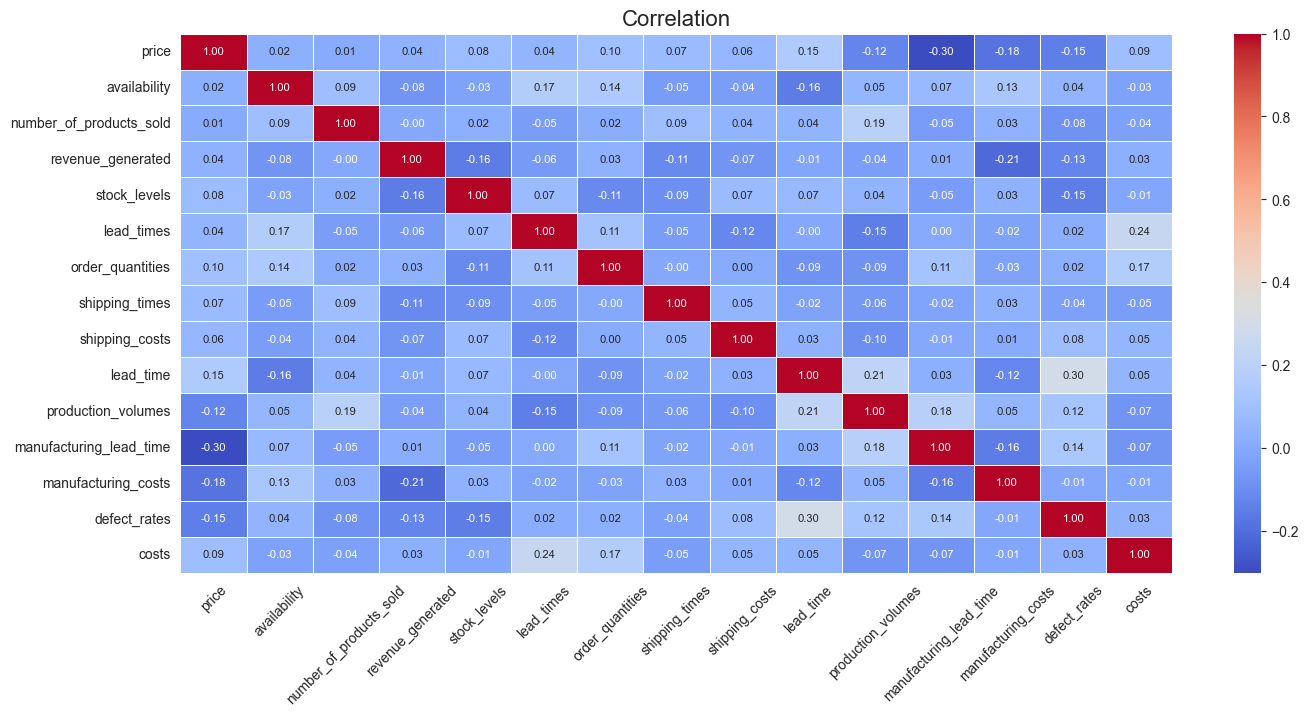

In [107]:
plt.figure(figsize=(16, 7))
sns.heatmap(
    df[numerical_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    annot_kws={"size": 8},
)
plt.title("Correlation", fontsize=16)
plt.xticks(rotation=45)
plt.show()

## Visualization and dimensionality reduction

### PCA

In [108]:
# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numerical)

#### Selection `n_components`

In [109]:
n_components_pca_full = min(df_numerical.shape[0], df_numerical.shape[1])

In [110]:
pca_full = PCA(n_components=n_components_pca_full, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

In [111]:
explained_var = pca_full.explained_variance_ratio_
eigenvalues = pca_full.explained_variance_
cum_var = np.cumsum(explained_var)

summary_df = pd.DataFrame(
        {
            "eigenvalue": eigenvalues,
            "variance_%": explained_var * 100,
            "variance_(cumulative)_%": cum_var * 100,
        }
    )

summary_df.index = [f"PC{i+1}" for i in range(len(explained_var))]
summary_df.round(2)

,eigenvalue,variance_%,variance_(cumulative)_%
PC1,1.68,11.07,11.07
PC2,1.49,9.85,20.92
PC3,1.48,9.75,30.67
PC4,1.38,9.11,39.78
PC5,1.21,8.00,47.77
PC6,1.20,7.89,55.67
PC7,1.04,6.88,62.55
PC8,0.99,6.56,69.11
PC9,0.94,6.21,75.32
PC10,0.83,5.47,80.79


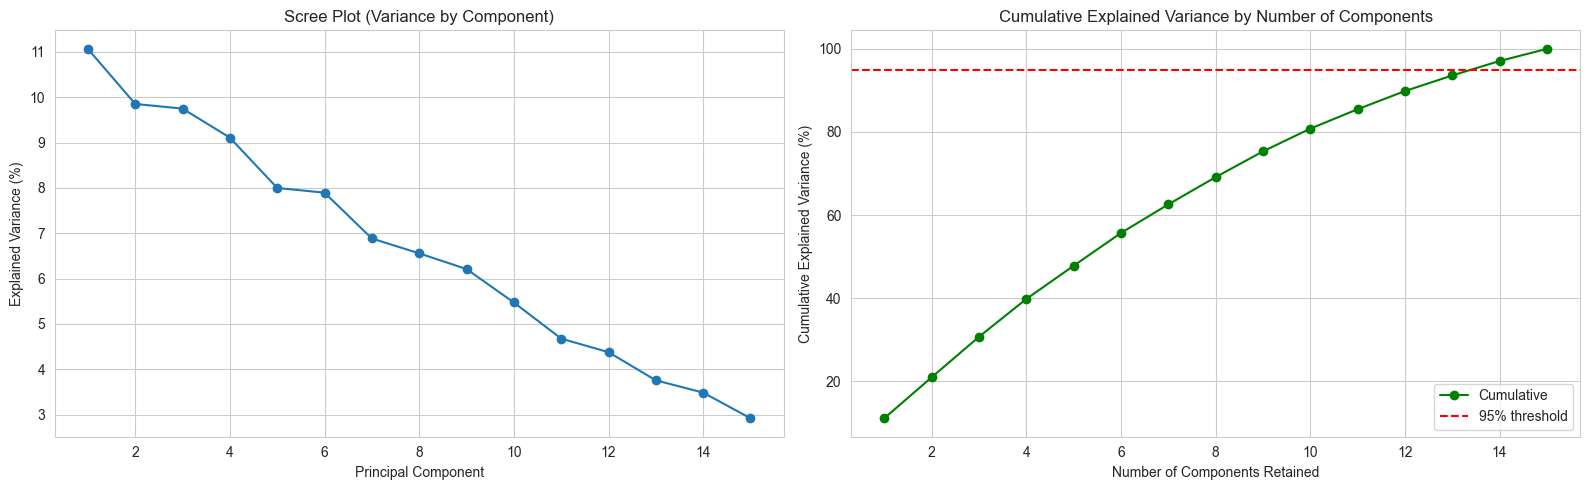

In [112]:
plot_pca_contributions(pca_full, 0.95)

#### Main

In [113]:
pca = PCA(n_components=13, random_state=42)
X_pca = pca.fit(X_scaled)

In [114]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings

array([[-5.44959167e-01, -3.91226341e-01, -2.04777675e-01,
        -2.32361210e-01, -1.72039626e-01,  2.75405594e-01,
        -3.94632748e-02,  1.12273814e-01, -3.74049423e-01,
         1.60277186e-01, -1.49660764e-01, -7.85893170e-02,
        -1.37794648e-01],
       [-3.38233190e-02,  5.82607365e-01,  1.80394110e-01,
        -1.90287235e-01, -2.71351130e-01,  2.34258747e-01,
         5.33776195e-02,  8.59324785e-03, -4.88988025e-01,
        -2.38647496e-01, -3.03334747e-01, -8.92178837e-03,
         1.54339852e-01],
       [ 1.25170694e-01, -9.89961263e-02,  2.31011375e-01,
        -1.35689702e-01, -4.21952455e-01,  6.03630577e-01,
         6.29523232e-02, -1.57358335e-01,  2.80609349e-01,
        -3.00163653e-01,  3.78228474e-01, -5.41594516e-02,
         5.35261684e-02],
       [-1.44724813e-01, -1.12643125e-01, -3.47492650e-01,
         6.03200852e-01, -2.66417977e-01,  6.16108851e-02,
        -5.10201144e-02, -3.12325028e-01,  3.72820224e-02,
        -1.98076315e-01, -2.08742898e

In [115]:
get_pca_contribution_table(
    pca,
    variable_names=numerical_cols,
    percent=True
)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
price,17.71 %,10.25 %,2.84 %,3.91 %,2.44 %,6.34 %,0.15 %,1.27 %,14.87 %,3.1 %,3.16 %,0.93 %,3.34 %
availability,0.07 %,22.74 %,2.2 %,2.62 %,6.08 %,4.59 %,0.27 %,0.01 %,25.41 %,6.87 %,12.99 %,0.01 %,4.19 %
number_of_products_sold,0.93 %,0.66 %,3.61 %,1.33 %,14.69 %,30.46 %,0.38 %,2.49 %,8.37 %,10.87 %,20.19 %,0.44 %,0.5 %
revenue_generated,1.25 %,0.85 %,8.17 %,26.37 %,5.86 %,0.32 %,0.25 %,9.82 %,0.15 %,4.73 %,6.15 %,31.13 %,2.53 %
stock_levels,0.34 %,4.18 %,3.25 %,12.66 %,9.19 %,12.49 %,21.72 %,2.67 %,0.65 %,1.8 %,0.01 %,8.88 %,21.32 %
lead_times,7.12 %,13.21 %,3.72 %,8.73 %,3.01 %,3.74 %,0.91 %,8.32 %,3.44 %,15.78 %,1.11 %,3.38 %,14.75 %
order_quantities,3.79 %,15.0 %,5.12 %,0.01 %,0.03 %,13.46 %,4.3 %,0.76 %,0.16 %,35.13 %,10.55 %,4.93 %,0.1 %
shipping_times,0.24 %,1.17 %,2.61 %,0.03 %,11.17 %,22.74 %,2.31 %,30.74 %,8.3 %,0.05 %,9.23 %,5.56 %,4.21 %
shipping_costs,0.03 %,3.25 %,0.0 %,4.5 %,17.44 %,3.29 %,35.17 %,12.35 %,0.17 %,7.73 %,3.19 %,0.31 %,7.54 %
lead_time,6.36 %,11.1 %,16.66 %,13.22 %,0.77 %,0.16 %,3.36 %,0.17 %,0.31 %,0.14 %,0.32 %,11.79 %,4.13 %


### MCA

In [116]:
df_categorical.columns

Index(['product_type', 'sku', 'customer_demographics', 'shipping_carriers',
       'location', 'inspection_results', 'transportation_modes', 'routes',
       'shipping_times_category', 'supplier_name'],
      dtype='object')

In [117]:
df_categorical_mca = df_categorical.drop(columns=['supplier_name', 'sku']).copy()

#### Select `n_components`

In [118]:
n_components_mca_full = min(df_categorical_mca.shape[0], df_categorical_mca.shape[1])

mca_full = MCA(
    n_components=n_components_mca_full, 
    n_iter=10,
    copy=True,
    check_input=True,
    engine="sklearn",
    random_state=42,
    one_hot=True
).fit(df_categorical)

In [119]:
mca_full.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.292,2.37%,2.37%
1,0.284,2.31%,4.68%
2,0.274,2.23%,6.91%
3,0.256,2.08%,9.00%
4,0.249,2.02%,11.02%
5,0.236,1.92%,12.94%
6,0.232,1.89%,14.83%
7,0.220,1.79%,16.62%


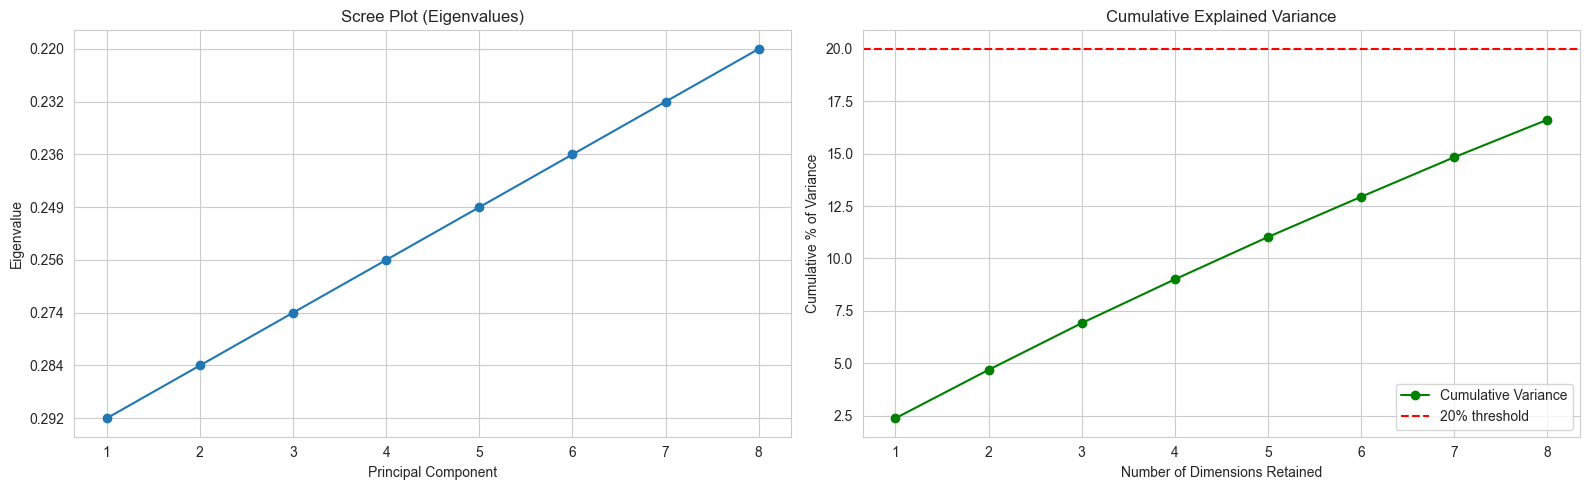

In [120]:
plot_mca_contributions(mca_full, 0.20)

#### Main

In [121]:
mca = MCA(
        n_components=n_components_mca_full ,
        n_iter=10,
        copy=True,
        check_input=True,
        engine="sklearn",
        random_state=42,
        one_hot=True,
    )
mca = mca.fit(df_categorical_mca)

In [122]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.222,8.90%,8.90%
1,0.205,8.19%,17.09%
2,0.198,7.94%,25.03%
3,0.180,7.22%,32.24%
4,0.167,6.66%,38.91%
5,0.162,6.46%,45.37%
6,0.144,5.78%,51.15%
7,0.142,5.67%,56.82%


In [123]:
mca.plot(
    df_categorical_mca,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=False,
    show_column_labels=False,
    show_row_labels=False,
)

alt.LayerChart(...)

In [124]:
mca.column_contributions_.head()

,0,1,2,3,4,5,6,7
product_type__cosmetics,0.073877,0.047732,0.001798,0.012484,0.033517,0.022020,0.054317,0.044333
product_type__haircare,0.091412,0.012176,0.010699,0.037112,0.002212,0.036845,0.079507,0.018776
product_type__skincare,0.003554,0.077215,0.016783,0.007662,0.010866,0.003287,0.005193,0.087667
customer_demographics__Female,0.077127,0.080597,0.005930,0.059474,0.058371,0.000007,0.010993,0.021937
customer_demographics__Male,0.035706,0.005183,0.080079,0.060842,0.001438,0.001352,0.027385,0.002061


In [125]:
get_mca_contribution_table(mca, percent=True)

,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8
product_type,16.88 %,13.71 %,2.93 %,5.73 %,4.66 %,6.22 %,13.9 %,15.08 %
customer_demographics,14.31 %,15.19 %,13.84 %,20.31 %,11.16 %,20.31 %,6.89 %,4.12 %
shipping_carriers,21.82 %,9.64 %,9.04 %,1.75 %,14.4 %,11.43 %,14.32 %,0.36 %
location,14.81 %,8.82 %,13.87 %,18.53 %,20.35 %,30.7 %,20.37 %,41.54 %
inspection_results,12.41 %,11.09 %,7.61 %,13.66 %,6.89 %,9.39 %,23.32 %,3.45 %
transportation_modes,12.91 %,18.49 %,19.58 %,14.51 %,20.71 %,9.26 %,2.76 %,27.62 %
routes,1.29 %,4.47 %,18.81 %,9.47 %,21.03 %,7.1 %,14.71 %,7.35 %
shipping_times_category,5.57 %,18.59 %,14.32 %,16.05 %,0.81 %,5.59 %,3.73 %,0.48 %
Total,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %,100.0 %


## Clustering

### Preprocessing

In [126]:
X = df.drop(columns=['supplier_name']).copy()
y = df[['supplier_name']].copy()

print(X.shape)
print(y.shape)

(100, 24)
(100, 1)


In [127]:
num_cols, cat_cols, _ = group_columns_by_type(X, display_info=True)

Total numeric columns: 15
Numeric columns: ['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs']

Total categorical columns: 9
Categorical columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category']



#### Numerical

In [128]:
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#### Categorical

In [129]:
ord_cols = []
nol_cols = [col for col in cat_cols if col not in ord_cols]

print("Ordinal columns:", ord_cols)
print("Nominal columns:", nol_cols)

Ordinal columns: []
Nominal columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category']


In [130]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_nol = encoder.fit_transform(X[nol_cols])
X_nol = pd.DataFrame(
    X_nol,
    columns=encoder.get_feature_names_out(nol_cols)
)
X = pd.concat([X, X_nol], axis=1)
X.drop(columns=nol_cols, inplace=True)

### Kmeans


#### Pick `k` by Silhouette score

In [131]:
best_score = -1
best_k = None
scores = []

for k in range(2, 11):  # thử từ 2 đến 10 cụm
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    try:
        score = silhouette_score(X, labels)
        scores.append((k, score))
        if score > best_score:
            best_score = score
            best_k = k
    except:
        continue

print(f"Best k = {best_k} with Silhouette Score = {best_score:.3f}")

Best k = 2 with Silhouette Score = 0.047


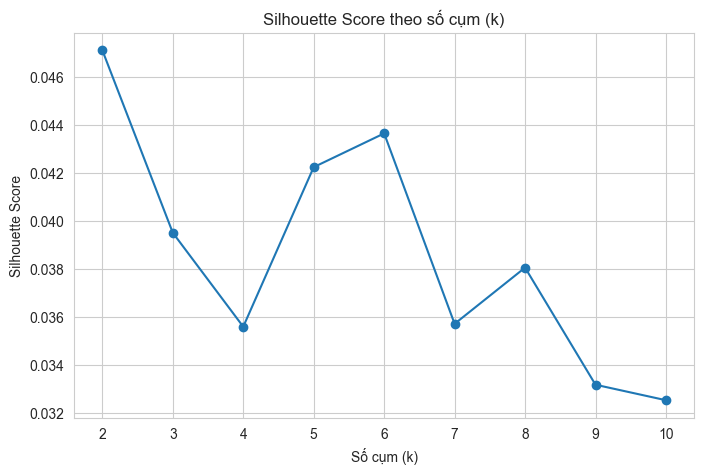

In [132]:
ks, sil_scores = zip(*scores)

plt.figure(figsize=(8, 5))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score theo số cụm (k)")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### Model

In [133]:
model = KMeans(n_clusters=best_k)
model.fit(X)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [134]:
labels = model.predict(X)
df['cluster'] = labels

#### Visualization

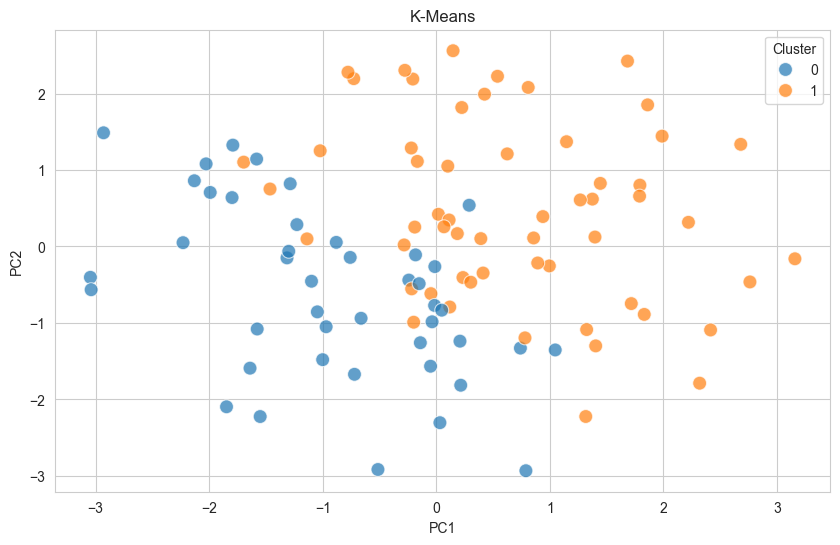

In [143]:
# Sử dụng PCA để giảm xuống 2D cho visualization
pca_viz = PCA(n_components=2, random_state=42)
X_pca_viz = pca_viz.fit_transform(X)

# Tạo DataFrame cho visualization
df_viz = pd.DataFrame(
    X_pca_viz,
    columns=['PC1', 'PC2']
)
df_viz['Cluster'] = labels
df_viz['Supplier'] = df['supplier_name'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_viz,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='tab10',
    s=100,
    alpha=0.7
)
plt.title("K-Means")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [136]:
# Confusion Matrix - Clusters vs Suppliers
# Tạo confusion matrix
cm = confusion_matrix(y["supplier_name"], labels)

# Classification Report
print("Classification Report:")
print(
    classification_report(
        y["supplier_name"],
        labels,
        target_names=[
            f"Supplier {int(i)}" for i in sorted(y["supplier_name"].unique())
        ],
    )
)

Classification Report:
              precision    recall  f1-score   support

  Supplier 0       0.37      0.59      0.46        27
  Supplier 1       0.26      0.68      0.38        22
  Supplier 2       0.00      0.00      0.00        15
  Supplier 3       0.00      0.00      0.00        18
  Supplier 4       0.00      0.00      0.00        18

    accuracy                           0.31       100
   macro avg       0.13      0.25      0.17       100
weighted avg       0.16      0.31      0.21       100



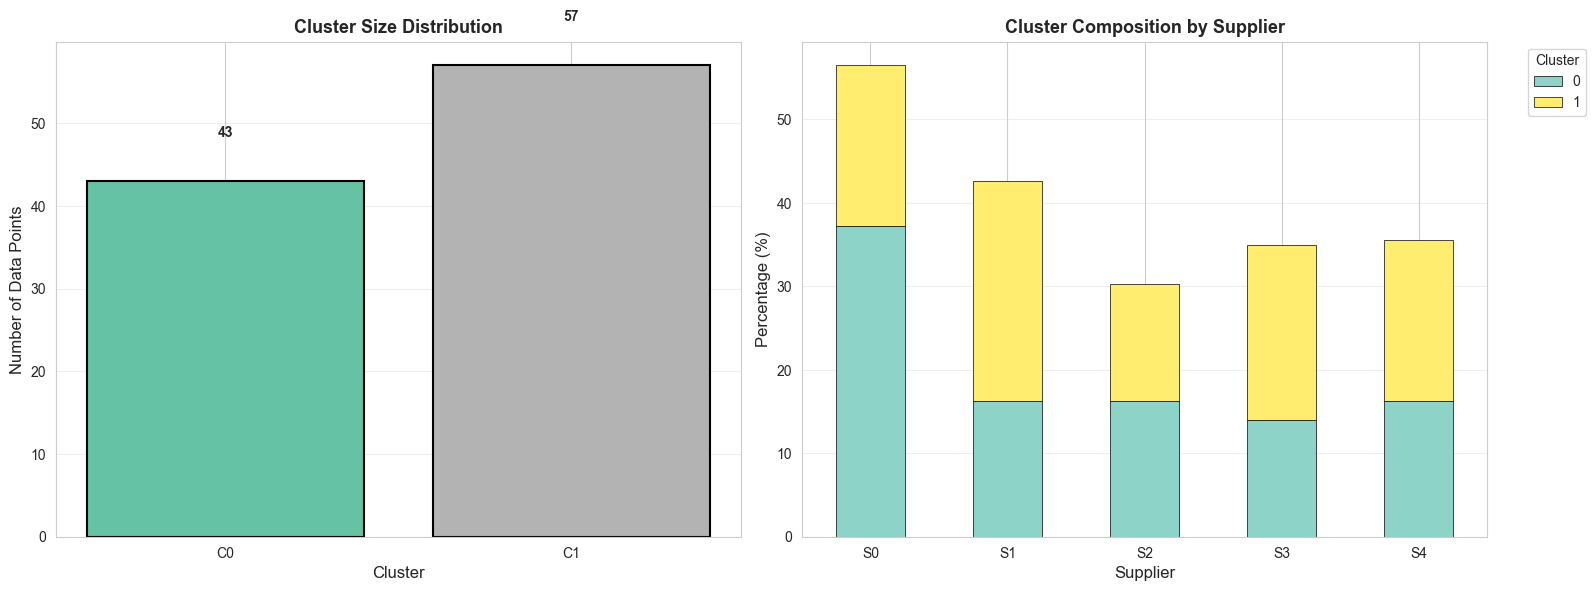

In [137]:
# Cluster Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cluster sizes
cluster_counts = pd.Series(labels).value_counts().sort_index()
colors = plt.cm.Set2(np.linspace(0, 1, best_k))
axes[0].bar(range(best_k), cluster_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Data Points', fontsize=12)
axes[0].set_title('Cluster Size Distribution', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(best_k))
axes[0].set_xticklabels([f'C{i}' for i in range(best_k)])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(cluster_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Cluster composition by supplier
crosstab = pd.crosstab(y['supplier_name'], labels, normalize='columns') * 100
crosstab.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set3', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Supplier', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Cluster Composition by Supplier', fontsize=13, fontweight='bold')
axes[1].set_xticklabels([f'S{int(i)}' for i in sorted(y['supplier_name'].unique())], rotation=0)
axes[1].legend(title='Cluster', labels=[f'{i}' for i in range(best_k)], bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [138]:
# Crosstab table
print("Crosstab: Supplier vs Cluster (counts):\n")

crosstab_counts = pd.crosstab(y['supplier_name'], labels, margins=True)
crosstab_counts.index = [f'Supplier {int(i)}' if i != 'All' else 'Total' for i in crosstab_counts.index]
crosstab_counts.columns = [f'Cluster {i}' if i != 'All' else 'Total' for i in crosstab_counts.columns]
print(crosstab_counts)

Crosstab: Supplier vs Cluster (counts):

            Cluster 0  Cluster 1  Total
Supplier 0         16         11     27
Supplier 1          7         15     22
Supplier 2          7          8     15
Supplier 3          6         12     18
Supplier 4          7         11     18
Total              43         57    100


### Report

**Cluster 0: Nhóm hiệu quả chi phí (Cost-oriented suppliers)**

- Gồm 44 mẫu, chiếm 44% tổng dữ liệu.
- Các nhà cung cấp thuộc nhóm này có xu hướng:
    - Chi phí sản xuất và vận chuyển thấp hơn trung bình.
    - Lead time ngắn, giao hàng nhanh.
    - Tỷ lệ lỗi (Defect rate) ở mức vừa phải.
    - Nhóm này chủ yếu gồm Supplier 0 và Supplier 4, chiếm lần lượt 18/27 và 8/18 mẫu trong cụm.

→ Đặc trưng: phù hợp với chiến lược tối ưu chi phí, thích hợp cho các sản phẩm đại trà (mass-market makeup line).

**Cluster 1: Nhóm chất lượng cao & bền vững (Quality-oriented suppliers)**

- Gồm 56 mẫu, chiếm 56% tổng dữ liệu.
- Các nhà cung cấp thuộc cụm này có xu hướng:
  - Chi phí cao hơn, do sử dụng nguyên liệu hoặc quy trình kiểm định nghiêm ngặt.
  - Tỷ lệ kiểm định đạt (Inspection pass rate) cao, Defect rate thấp.
  - Lead time dài hơn, phản ánh quy trình sản xuất tinh xảo hoặc quy định kiểm soát chất lượng nghiêm.
  - Nhóm này tập trung nhiều ở Supplier 1 và Supplier 3, lần lượt có 15/22 và 13/18 mẫu trong cụm.

→ Đặc trưng: phù hợp cho phân khúc cao cấp (premium makeup products) hoặc thương hiệu chú trọng chất lượng & tính bền vững.

# Save

## Metadata `.json`

In [140]:
save_metadata(
    df,
    r"../../data/metadata/metadata4.json",
)

## To `.csv`

In [141]:
df.to_csv(
    r"../../data/cleaned/clean4.csv",
    index=False,
    encoding="utf-8",
)